## 1. Define tools and model

In [2]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model

import os

model = init_chat_model(
    model="deepseek-chat",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)


@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """

    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`

    Args:
        a: First int
        b: Second int
    """

    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

## 2. Define state

In [3]:

from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

## 3. Define model node

In [11]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""
    
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpfil assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get("llm_calls", 0) + 1
    }


## 4. Define tool node

In [16]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call['id']))
    
    return {"messages": result}

## 5. define end logic

In [17]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessageState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tool_node"
    
    return END

## 6. Build and compile the agent

In [18]:
agent_builder = StateGraph(MessageState)


agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)


agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)

agent_builder.add_edge("tool_node", "llm_call")

# compile the agent
agent = agent_builder.compile()


### show the agent

![graph](./output.png)

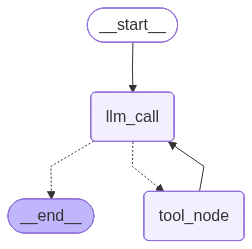

In [9]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Invoke

In [19]:
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

I'll add 3 and 4 for you.
Tool Calls:
  add (call_00_nyPr7MFCfnXNet9XEdDyiPxH)
 Call ID: call_00_nyPr7MFCfnXNet9XEdDyiPxH
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
